# VANS: Visual Analogy Network Solver

**Deep Learning for Computer Vision - Final Project**

**Team Members:** Mikul Saravanan, Alice Lin, Angel Wu

---

## Project Overview

This notebook implements VANS, a deep learning system that solves Raven's Progressive Matrices (RPM) - visual analogy puzzles used in IQ tests. Our approach uses:

- **DINOv2-L** (frozen) as a visual feature extractor (1024-dim features)
- **Transformer-based Context Encoder** with row/column positional embeddings
- **Cross-attention Rule Reasoning Module** for scoring candidate answers
- **I-RAVEN Dataset** (bias-corrected version of RAVEN)

### Architecture

```
I-RAVEN Problem (8 context + 8 candidates)
              │
              ▼
┌─────────────────────────────┐
│  DINOv2-L (frozen)          │  ← 1024-dim features per image
│  Pre-extract all features   │
└─────────────────────────────┘
              │
              ▼
┌─────────────────────────────┐
│  Context Encoder            │  ← 4-layer Transformer + positional embeddings
│  [8 x 1024] → [512]         │
└─────────────────────────────┘
              │
              ▼
┌─────────────────────────────┐
│  Rule Reasoning Module      │  ← Cross-attention: candidates attend to context
│  Score 8 candidates         │
└─────────────────────────────┘
              │
              ▼
        Softmax → Answer
```

**Target Accuracy:** 85-88% on I-RAVEN test set

---
# SECTION 1: COLAB SETUP & OPTIMIZATION
---

In [27]:
#@title 1.1 Environment Configuration
import os

# Enable MPS fallback for unsupported ops (required for DINOv2 on Apple Silicon)
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch
import gc

# ========== CONFIGURATION FLAGS ==========
USE_COLAB = False  # Set to True when running on Google Colab
TEST_MODE = False  # Set to True for quick testing (50 samples, 1 epoch)

# ========== DATA SAMPLING ==========
# Controls how many samples PER CONFIG to use for feature extraction
# Options:
#   - 50: Quick test (~5 min feature extraction)
#   - 2000: Fast training (~45 min extraction, ~80% accuracy)
#   - 5000: Good results (~1.5 hr extraction, ~85% accuracy)  <-- CURRENT
#   - 10000: Full dataset (~3 hr extraction, best accuracy)
#   - None: Use ALL available data (same as 10000 for RAVEN-10000)
NUM_SAMPLES_PER_CONFIG = 5000

# ========== CONFIG SHORT NAMES (for display) ==========
CONFIG_SHORT = {
    'center_single': 'center',
    'distribute_four': 'dist_4',
    'distribute_nine': 'dist_9',
    'left_center_single_right_center_single': 'left_right',
    'up_center_single_down_center_single': 'up_down',
    'in_center_single_out_center_single': 'in_out',
    'in_distribute_four_out_center_single': 'in_out_grid',
}

# ========== DIRECTORY CONFIGURATION ==========
if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = '/content/drive/MyDrive/VANS'
    DATA_DIR = os.path.join(BASE_DIR, 'data', 'I-RAVEN')
    REPO_DIR = '/content/RAVEN'
else:
    # Local paths
    NOTEBOOK_DIR = os.getcwd()
    BASE_DIR = os.path.join(NOTEBOOK_DIR, 'VANS_output')
    DATA_DIR = '/Users/mikul/Downloads/RAVEN-10000'
    REPO_DIR = os.path.join(NOTEBOOK_DIR, 'RAVEN')

# Create output directories
FEATURES_DIR = os.path.join(BASE_DIR, 'features')
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')

for d in [BASE_DIR, FEATURES_DIR, CHECKPOINT_DIR, RESULTS_DIR]:
    os.makedirs(d, exist_ok=True)

# ========== TRAINING HYPERPARAMETERS ==========
BATCH_SIZE = 64 if not TEST_MODE else 8
MAX_EPOCHS = 100 if not TEST_MODE else 1
PATIENCE = 15 if not TEST_MODE else 1
LEARNING_RATE = 1e-4

# ========== GPU/DEVICE SETUP ==========
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

# ========== PRINT CONFIGURATION ==========
print("=" * 60)
print("VANS CONFIGURATION")
print("=" * 60)
print(f"USE_COLAB:              {USE_COLAB}")
print(f"TEST_MODE:              {TEST_MODE}")
print(f"NUM_SAMPLES_PER_CONFIG: {NUM_SAMPLES_PER_CONFIG}")
print(f"DEVICE:                 {DEVICE}")
print(f"BATCH_SIZE:             {BATCH_SIZE}")
print(f"MAX_EPOCHS:             {MAX_EPOCHS}")
print(f"PATIENCE:               {PATIENCE}")
print(f"")
print(f"DATA_DIR:               {DATA_DIR}")
print(f"FEATURES_DIR:           {FEATURES_DIR}")
print(f"CHECKPOINT_DIR:         {CHECKPOINT_DIR}")
print("=" * 60)

if DEVICE.type == 'mps':
    print("\n[OK] MPS fallback enabled for unsupported ops")

# Verify data exists
if os.path.exists(DATA_DIR):
    subdirs = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
    print(f"\n[OK] Found {len(subdirs)} configurations in DATA_DIR")
    total_available = 0
    for sd in sorted(subdirs):
        count = len([f for f in os.listdir(os.path.join(DATA_DIR, sd)) if f.endswith('.npz')])
        total_available += count
        will_use = min(count, NUM_SAMPLES_PER_CONFIG) if NUM_SAMPLES_PER_CONFIG else count
        print(f"    {sd}: {count} available, will use {will_use}")
    print(f"\n    Total available: {total_available}")
    print(f"    Will use: ~{len(subdirs) * (NUM_SAMPLES_PER_CONFIG or 10000)} samples")
else:
    print(f"\n[ERROR] DATA_DIR not found: {DATA_DIR}")

VANS CONFIGURATION
USE_COLAB:              False
TEST_MODE:              False
NUM_SAMPLES_PER_CONFIG: 5000
DEVICE:                 mps
BATCH_SIZE:             64
MAX_EPOCHS:             100
PATIENCE:               15

DATA_DIR:               /Users/mikul/Downloads/RAVEN-10000
FEATURES_DIR:           /Users/mikul/Library/CloudStorage/OneDrive-Personal/College Undergrad/Junior Semester 1/Deep Learning for CV/VANS_output/features
CHECKPOINT_DIR:         /Users/mikul/Library/CloudStorage/OneDrive-Personal/College Undergrad/Junior Semester 1/Deep Learning for CV/VANS_output/checkpoints

[OK] MPS fallback enabled for unsupported ops

[OK] Found 7 configurations in DATA_DIR
    center_single: 10000 available, will use 5000
    distribute_four: 10000 available, will use 5000
    distribute_nine: 10000 available, will use 5000
    in_center_single_out_center_single: 10000 available, will use 5000
    in_distribute_four_out_center_single: 10000 available, will use 5000
    left_center_single_ri

In [28]:
#@title 1.2 GPU Check & Optimization
import torch
import gc

print("GPU Information:")

# Check for NVIDIA GPU
try:
    import subprocess
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    if result.returncode == 0:
        print(result.stdout[:500])
except:
    print("nvidia-smi not found (not NVIDIA GPU)")

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

# Set device with priority: CUDA > MPS > CPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"\nUsing CUDA GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    
    # GPU optimizations
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    print("[OK] GPU optimizations enabled (TF32, cuDNN benchmark)")
    
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print(f"\n[OK] Using Apple Silicon GPU (MPS)")
    print("MPS provides GPU acceleration on M1/M2/M3 Macs")
    
else:
    DEVICE = torch.device('cpu')
    print(f"\n[WARN] No GPU detected - training will be slow!")

# Memory cleanup
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print(f"\n[OK] DEVICE = {DEVICE}")


GPU Information:
nvidia-smi not found (not NVIDIA GPU)

PyTorch version: 2.5.1
CUDA available: False
MPS available: True

[OK] Using Apple Silicon GPU (MPS)
MPS provides GPU acceleration on M1/M2/M3 Macs

[OK] DEVICE = mps


In [29]:
#@title 1.3 Install Dependencies
import subprocess
import sys

# Check if we need to install packages
try:
    import einops
    print("[OK] Dependencies already installed")
except ImportError:
    print("Installing dependencies...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", 
                          "torch", "torchvision", "torchaudio", "--upgrade"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                          "tqdm", "matplotlib", "seaborn", "pandas", "numpy", "scipy", "einops"])
    print("[OK] Dependencies installed")

[OK] Dependencies already installed


In [30]:
#@title 1.4 Mount Drive & Create Directories
import os

# Mount Google Drive if on Colab
if USE_COLAB:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("[OK] Google Drive mounted")
    except ImportError:
        print("[WARN] Not running on Colab - skipping drive mount")

# Create all project directories
dirs_to_create = [DATA_DIR, FEATURES_DIR, CHECKPOINT_DIR, RESULTS_DIR]
for d in dirs_to_create:
    os.makedirs(d, exist_ok=True)
    print(f"[OK] Directory ready: {d}")

print(f"\n[OK] All directories created under {BASE_DIR}")

[OK] Directory ready: /Users/mikul/Downloads/RAVEN-10000
[OK] Directory ready: /Users/mikul/Library/CloudStorage/OneDrive-Personal/College Undergrad/Junior Semester 1/Deep Learning for CV/VANS_output/features
[OK] Directory ready: /Users/mikul/Library/CloudStorage/OneDrive-Personal/College Undergrad/Junior Semester 1/Deep Learning for CV/VANS_output/checkpoints
[OK] Directory ready: /Users/mikul/Library/CloudStorage/OneDrive-Personal/College Undergrad/Junior Semester 1/Deep Learning for CV/VANS_output/results

[OK] All directories created under /Users/mikul/Library/CloudStorage/OneDrive-Personal/College Undergrad/Junior Semester 1/Deep Learning for CV/VANS_output


#@title 1.5 Set Seeds & Device
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(SEED)
print(f"[OK] Seed set to {SEED}")

In [31]:
#@title 2.1 Clone RAVEN Repository
import os
import subprocess

print(f"Target directory: {REPO_DIR}")

if not os.path.exists(REPO_DIR):
    print("Cloning RAVEN repository (original, stable version)...")
    result = subprocess.run(
        ['git', 'clone', 'https://github.com/WellyZhang/RAVEN.git', REPO_DIR],
        capture_output=True, text=True
    )
    if result.returncode == 0:
        print("[OK] RAVEN repository cloned")
    else:
        print(f"[ERROR] Clone failed: {result.stderr}")
else:
    print("[OK] RAVEN repository already exists")

# Verify contents
print(f"\nRepository contents:")
if os.path.exists(REPO_DIR):
    for item in os.listdir(REPO_DIR):
        print(f"  {item}")

Target directory: /Users/mikul/Library/CloudStorage/OneDrive-Personal/College Undergrad/Junior Semester 1/Deep Learning for CV/RAVEN
[OK] RAVEN repository already exists

Repository contents:
  LICENSE
  requirements.txt
  dataset
  README.md
  .gitignore
  .git
  assets
  CLAUDE.md
  src


In [32]:
#@title 2.2 Verify RAVEN Dataset
import os

# Data should already be configured in cell 1.1
print(f"Checking data at: {DATA_DIR}")

if os.path.exists(DATA_DIR):
    configs = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
    print(f"\nFound {len(configs)} configurations:")
    
    total_files = 0
    for config in sorted(configs):
        config_path = os.path.join(DATA_DIR, config)
        npz_files = [f for f in os.listdir(config_path) if f.endswith('.npz')]
        train = len([f for f in npz_files if 'train' in f])
        val = len([f for f in npz_files if 'val' in f])
        test = len([f for f in npz_files if 'test' in f])
        total_files += len(npz_files)
        print(f"  {config}: {len(npz_files)} total (train={train}, val={val}, test={test})")
    
    print(f"\n[OK] Total: {total_files} .npz files")
else:
    print(f"[ERROR] Data directory not found: {DATA_DIR}")
    print("Please update DATA_DIR in cell 1.1 to point to your RAVEN data")


Checking data at: /Users/mikul/Downloads/RAVEN-10000

Found 7 configurations:
  center_single: 10000 total (train=6000, val=2000, test=2000)
  distribute_four: 10000 total (train=6000, val=2000, test=2000)
  distribute_nine: 10000 total (train=6000, val=2000, test=2000)
  in_center_single_out_center_single: 10000 total (train=6000, val=2000, test=2000)
  in_distribute_four_out_center_single: 10000 total (train=6000, val=2000, test=2000)
  left_center_single_right_center_single: 10000 total (train=6000, val=2000, test=2000)
  up_center_single_down_center_single: 10000 total (train=6000, val=2000, test=2000)

[OK] Total: 70000 .npz files


In [33]:
#@title 2.3 Verify Data Structure
import os
import numpy as np

print("Dataset Structure:")
print("-" * 60)

# Auto-detect configurations from DATA_DIR
configs = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])

total_samples = 0
for config in configs:
    config_dir = os.path.join(DATA_DIR, config)
    files = [f for f in os.listdir(config_dir) if f.endswith('.npz')]
    train = len([f for f in files if 'train' in f])
    val = len([f for f in files if 'val' in f])
    test = len([f for f in files if 'test' in f])
    total_samples += len(files)
    print(f"{config[:25]:25} | train: {train:5} | val: {val:4} | test: {test:4}")

print("-" * 60)
print(f"Total: {total_samples} samples across {len(configs)} configurations")

# Verify single sample structure
sample_config = configs[0] if configs else None
if sample_config:
    sample_dir = os.path.join(DATA_DIR, sample_config)
    sample_files = [f for f in os.listdir(sample_dir) if f.endswith('.npz')]
    if sample_files:
        sample_path = os.path.join(sample_dir, sample_files[0])
        data = np.load(sample_path)
        print(f"\nSample file structure ({sample_files[0]}):")
        for key in data.keys():
            val = data[key]
            if hasattr(val, 'shape'):
                print(f"  {key}: shape={val.shape}, dtype={val.dtype}")
            else:
                print(f"  {key}: {val}")


Dataset Structure:
------------------------------------------------------------
center_single             | train:  6000 | val: 2000 | test: 2000
distribute_four           | train:  6000 | val: 2000 | test: 2000
distribute_nine           | train:  6000 | val: 2000 | test: 2000
in_center_single_out_cent | train:  6000 | val: 2000 | test: 2000
in_distribute_four_out_ce | train:  6000 | val: 2000 | test: 2000
left_center_single_right_ | train:  6000 | val: 2000 | test: 2000
up_center_single_down_cen | train:  6000 | val: 2000 | test: 2000
------------------------------------------------------------
Total: 70000 samples across 7 configurations

Sample file structure (RAVEN_8386_val.npz):
  target: shape=(), dtype=int64
  predict: shape=(), dtype=int64
  image: shape=(16, 160, 160), dtype=uint8
  meta_matrix: shape=(8, 9), dtype=uint8
  meta_structure: shape=(21,), dtype=uint8
  meta_target: shape=(9,), dtype=uint8
  structure: shape=(8,), dtype=|S13


---
# SECTION 3: FEATURE EXTRACTION (Pre-compute)

**CRITICAL:** Pre-extracting DINOv2 features saves ~10x training time.
- Without caching: ~50 hours training
- With caching: ~2-4 hours training

Run this section once, then skip in future sessions.

---

In [34]:
#@title 3.1 Load DINOv2-L Backbone
import torch

print("Loading DINOv2-L (this may take a minute)...")

# Load DINOv2-L (Large) - 1024-dim features
backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
backbone = backbone.eval().to(DEVICE)

# Freeze all parameters
for param in backbone.parameters():
    param.requires_grad = False

num_params = sum(p.numel() for p in backbone.parameters())
print(f"\n✓ DINOv2-L loaded: {num_params/1e6:.1f}M params")
print(f"✓ Output dimension: 1024")

Loading DINOv2-L (this may take a minute)...


Using cache found in /Users/mikul/.cache/torch/hub/facebookresearch_dinov2_main



✓ DINOv2-L loaded: 304.4M params
✓ Output dimension: 1024


In [35]:
#@title 3.2 Extract & Cache All Features
import os
import glob
import numpy as np
import torch
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

# Use torchvision transforms instead of F.interpolate (MPS compatible)
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Uses PIL, works on CPU
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_panels(images):
    """Convert [N, 160, 160] grayscale to [N, 3, 224, 224] normalized RGB."""
    panels = []
    for img in images:
        pil_img = Image.fromarray(img).convert('RGB')
        tensor = preprocess_transform(pil_img)
        panels.append(tensor)
    return torch.stack(panels)

def extract_features_batch(backbone, panels, batch_size=16):
    """Extract DINOv2 features for a batch of panels."""
    features = []
    for i in range(0, len(panels), batch_size):
        batch = panels[i:i+batch_size].to(DEVICE)
        with torch.no_grad():
            feat = backbone(batch)
        features.append(feat.cpu())
    return torch.cat(features, dim=0)

# Feature file path
features_file = os.path.join(FEATURES_DIR, 'all_features.pt')

# Auto-detect configurations from DATA_DIR
all_configs = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
expected_per_config = NUM_SAMPLES_PER_CONFIG or 10000
expected_total = len(all_configs) * expected_per_config

# Load existing features if available
all_features = {}
if os.path.exists(features_file):
    print("Loading existing features...")
    all_features = torch.load(features_file, weights_only=False)
    print(f"  Loaded {len(all_features)} existing samples")
    
    # Count samples per config
    existing_by_config = {}
    for k, v in all_features.items():
        cfg = v['config']
        existing_by_config[cfg] = existing_by_config.get(cfg, 0) + 1
    
    print("  Existing by config:")
    for cfg in all_configs:
        count = existing_by_config.get(cfg, 0)
        print(f"    {cfg}: {count}/{expected_per_config}")

# Check which configs need extraction
configs_to_process = []
existing_by_config = {}
for k, v in all_features.items():
    cfg = v['config']
    existing_by_config[cfg] = existing_by_config.get(cfg, 0) + 1

for cfg in all_configs:
    existing = existing_by_config.get(cfg, 0)
    if existing < expected_per_config * 0.9:  # Need at least 90%
        configs_to_process.append(cfg)

if not configs_to_process:
    print(f"\n[OK] All features already cached!")
    print(f"    Total: {len(all_features)} samples")
    train_count = sum(1 for k in all_features.keys() if 'train' in k)
    val_count = sum(1 for k in all_features.keys() if 'val' in k)
    test_count = sum(1 for k in all_features.keys() if 'test' in k)
    print(f"    Train: {train_count}, Val: {val_count}, Test: {test_count}")
else:
    print(f"\nNeed to extract features for: {configs_to_process}")
    print(f"Using {NUM_SAMPLES_PER_CONFIG or 'ALL'} samples per config")
    print(f"Device: {DEVICE}")
    
    for config in configs_to_process:
        config_dir = os.path.join(DATA_DIR, config)
        files = sorted(glob.glob(os.path.join(config_dir, '*.npz')))
        
        # Limit files if NUM_SAMPLES_PER_CONFIG is set
        if NUM_SAMPLES_PER_CONFIG:
            files = files[:NUM_SAMPLES_PER_CONFIG]
        
        # Skip files we already have
        files_to_process = []
        for f in files:
            key = os.path.basename(f)
            if key not in all_features:
                files_to_process.append(f)
        
        if not files_to_process:
            print(f"\n[OK] {config}: Already complete")
            continue
            
        print(f"\nProcessing {config}: {len(files_to_process)} new files")
        
        for filepath in tqdm(files_to_process, desc=config):
            try:
                data = np.load(filepath)
                images = data['image']
                target = int(data['target'])
                
                panels = preprocess_panels(images)
                features = extract_features_batch(backbone, panels)
                
                key = os.path.basename(filepath)
                all_features[key] = {
                    'context': features[:8],
                    'candidates': features[8:],
                    'target': target,
                    'config': config
                }
            except Exception as e:
                print(f"Error: {filepath}: {e}")
                continue
        
        # Save checkpoint after each config
        torch.save(all_features, features_file)
        print(f"  Saved checkpoint: {len(all_features)} samples total")
    
    # Final stats
    print(f"\n[OK] Feature extraction complete!")
    print(f"    Total: {len(all_features)} samples")
    train_count = sum(1 for k in all_features.keys() if 'train' in k)
    val_count = sum(1 for k in all_features.keys() if 'val' in k)
    test_count = sum(1 for k in all_features.keys() if 'test' in k)
    print(f"    Train: {train_count}, Val: {val_count}, Test: {test_count}")

Loading existing features...
  Loaded 35000 existing samples
  Existing by config:
    center_single: 5000/5000
    distribute_four: 5000/5000
    distribute_nine: 5000/5000
    in_center_single_out_center_single: 5000/5000
    in_distribute_four_out_center_single: 5000/5000
    left_center_single_right_center_single: 5000/5000
    up_center_single_down_center_single: 5000/5000

[OK] All features already cached!
    Total: 35000 samples
    Train: 21028, Val: 6986, Test: 6986


In [36]:
#@title 3.3 Verify Cached Features
import torch
import os

features_file = os.path.join(FEATURES_DIR, 'all_features.pt')

if not os.path.exists(features_file):
    print(f"[ERROR] Features file not found: {features_file}")
    print("\nYou need to run the previous cells first:")
    print("  1. Section 2: Clone repo & generate I-RAVEN data")
    print("  2. Cell 3.1: Load DINOv2 backbone")
    print("  3. Cell 3.2: Extract & cache features")
else:
    print("Loading cached features...")
    features = torch.load(features_file, weights_only=False)
    print(f"[OK] Total samples: {len(features)}")

    # Check one sample
    sample_key = list(features.keys())[0]
    sample = features[sample_key]
    print(f"\nSample: {sample_key}")
    print(f"  Context shape: {sample['context'].shape}")
    print(f"  Candidates shape: {sample['candidates'].shape}")
    print(f"  Target: {sample['target']}")
    print(f"  Config: {sample['config']}")

    # Count by split
    splits = {'train': 0, 'val': 0, 'test': 0}
    configs_count = {}

    for key in features.keys():
        for split in splits:
            if split in key:
                splits[split] += 1
                break
        cfg = features[key]['config']
        short_name = CONFIG_SHORT.get(cfg, cfg[:15])
        configs_count[short_name] = configs_count.get(short_name, 0) + 1

    print(f"\nSplit counts: {splits}")
    print(f"Config counts: {configs_count}")

Loading cached features...
[OK] Total samples: 35000

Sample: RAVEN_0_train.npz
  Context shape: torch.Size([8, 1024])
  Candidates shape: torch.Size([8, 1024])
  Target: 6
  Config: up_center_single_down_center_single

Split counts: {'train': 21028, 'val': 6986, 'test': 6986}
Config counts: {'up_down': 5000, 'center': 5000, 'dist_4': 5000, 'dist_9': 5000, 'in_out': 5000, 'in_out_grid': 5000, 'left_right': 5000}


---
# SECTION 4: DATASET & DATALOADER
---

In [37]:
#@title 4.1 CachedFeatureDataset Class
import torch
import os
from torch.utils.data import Dataset, DataLoader

class CachedFeatureDataset(Dataset):
    """Dataset using pre-extracted DINOv2 features.
    
    Handles two feature formats:
    1. Split format: {'context': [8, 1024], 'candidates': [8, 1024], ...}
    2. Combined format: {'features': [16, 1024], ...} - from standalone extraction script
    """
    
    def __init__(self, features_dict, split='train'):
        """
        Args:
            features_dict: Dictionary loaded from all_features.pt
            split: 'train', 'val', or 'test'
        """
        self.samples = []
        for key, value in features_dict.items():
            if split in key:
                # Handle both feature formats
                if 'context' in value and 'candidates' in value:
                    # Split format (from notebook extraction)
                    context = value['context']
                    candidates = value['candidates']
                elif 'features' in value:
                    # Combined format (from standalone extraction script)
                    # features is [16, 1024] - first 8 are context, last 8 are candidates
                    features = value['features']
                    context = features[:8]
                    candidates = features[8:]
                else:
                    print(f"Warning: Unknown format for key {key}, skipping")
                    continue
                
                self.samples.append({
                    'context': context,           # [8, 1024]
                    'candidates': candidates,     # [8, 1024]
                    'target': value['target'],
                    'config': value['config'],
                    'key': key
                })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        return {
            'context': sample['context'].float(),
            'candidates': sample['candidates'].float(),
            'target': torch.tensor(sample['target'], dtype=torch.long),
            'config': sample['config']
        }

# Load features and create datasets
features_file = os.path.join(FEATURES_DIR, 'all_features.pt')

if not os.path.exists(features_file):
    print(f"[ERROR] Features file not found: {features_file}")
    print("Run Section 3 first to extract features.")
else:
    print("Loading cached features...")
    features = torch.load(features_file, weights_only=False)
    
    # Check feature format
    sample_key = list(features.keys())[0]
    sample_value = features[sample_key]
    if 'context' in sample_value:
        print(f"  Feature format: split (context + candidates)")
    elif 'features' in sample_value:
        print(f"  Feature format: combined (will auto-split)")
    
    train_dataset = CachedFeatureDataset(features, split='train')
    val_dataset = CachedFeatureDataset(features, split='val')
    test_dataset = CachedFeatureDataset(features, split='test')

    print(f"\n[OK] Datasets created:")
    print(f"  Train: {len(train_dataset)} samples")
    print(f"  Val:   {len(val_dataset)} samples")
    print(f"  Test:  {len(test_dataset)} samples")

Loading cached features...
  Feature format: split (context + candidates)

[OK] Datasets created:
  Train: 21028 samples
  Val:   6986 samples
  Test:  6986 samples


In [38]:
#@title 4.2 Create DataLoaders

# Check if datasets exist from previous cell
if 'train_dataset' not in dir():
    print("[ERROR] Datasets not created. Run cell 4.1 first.")
    print("        (And make sure you've run Section 3 to extract features)")
else:
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
        num_workers=0,  # Use 0 for local to avoid multiprocessing issues
        pin_memory=True, 
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,
        num_workers=0, 
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,
        num_workers=0, 
        pin_memory=True
    )

    print(f"[OK] DataLoaders created (batch_size={BATCH_SIZE}):")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches:   {len(val_loader)}")
    print(f"  Test batches:  {len(test_loader)}")

    # Verify batch
    sample_batch = next(iter(train_loader))
    print(f"\nSample batch shapes:")
    print(f"  Context: {sample_batch['context'].shape}")
    print(f"  Candidates: {sample_batch['candidates'].shape}")
    print(f"  Targets: {sample_batch['target'].shape}")

[OK] DataLoaders created (batch_size=64):
  Train batches: 328
  Val batches:   110
  Test batches:  110

Sample batch shapes:
  Context: torch.Size([64, 8, 1024])
  Candidates: torch.Size([64, 8, 1024])
  Targets: torch.Size([64])


---
# SECTION 5: MODEL ARCHITECTURE
---

In [39]:
#@title 5.1 ContextEncoder
import torch
import torch.nn as nn

class ContextEncoder(nn.Module):
    """
    Encodes 8 context panels with structural positional information.
    
    The 8 context panels form a 3x3 grid with the bottom-right missing:
    [0,0] [0,1] [0,2]
    [1,0] [1,1] [1,2]
    [2,0] [2,1]  ???
    
    Uses row/column embeddings to capture the grid structure.
    """
    
    def __init__(self, feature_dim=1024, hidden_dim=512, num_heads=8, num_layers=4, dropout=0.1):
        super().__init__()
        
        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Positional embeddings for 8 positions
        self.position_embed = nn.Parameter(torch.randn(8, hidden_dim) * 0.02)
        
        # Row/Column embeddings for structural awareness
        self.row_embed = nn.Parameter(torch.randn(3, hidden_dim // 2) * 0.02)
        self.col_embed = nn.Parameter(torch.randn(3, hidden_dim // 2) * 0.02)
        
        # Position indices for each of the 8 context panels
        # Order: (0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1)
        self.register_buffer('row_idx', torch.tensor([0, 0, 0, 1, 1, 1, 2, 2]))
        self.register_buffer('col_idx', torch.tensor([0, 1, 2, 0, 1, 2, 0, 1]))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Context aggregation via learnable query
        self.context_query = nn.Parameter(torch.randn(1, hidden_dim) * 0.02)
        self.cross_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
    
    def forward(self, context_features):
        """
        Args:
            context_features: [B, 8, 1024] - 8 context panel features
        
        Returns:
            context_repr: [B, 512] - aggregated context representation
            panel_features: [B, 8, 512] - individual panel features
        """
        B = context_features.shape[0]
        
        # Project to hidden dimension
        x = self.input_proj(context_features)  # [B, 8, 512]
        
        # Add positional embeddings
        x = x + self.position_embed.unsqueeze(0)
        
        # Add row/col embeddings for structural awareness
        row_emb = self.row_embed[self.row_idx]  # [8, 256]
        col_emb = self.col_embed[self.col_idx]  # [8, 256]
        struct_emb = torch.cat([row_emb, col_emb], dim=-1)  # [8, 512]
        x = x + struct_emb.unsqueeze(0)
        
        # Transformer encoding (captures row/column patterns)
        panel_features = self.transformer(x)  # [B, 8, 512]
        
        # Aggregate to single context vector using learnable query
        query = self.context_query.unsqueeze(0).expand(B, -1, -1)  # [B, 1, 512]
        context_repr, _ = self.cross_attn(query, panel_features, panel_features)
        context_repr = context_repr.squeeze(1)  # [B, 512]
        
        return context_repr, panel_features

print("✓ ContextEncoder defined")

✓ ContextEncoder defined


In [40]:
#@title 5.2 RuleReasoningModule
class RuleReasoningModule(nn.Module):
    """
    Scores candidate answers based on context using cross-attention.
    
    Each candidate attends to the context panels to determine how well
    it completes the pattern. Self-attention among candidates provides
    contrastive awareness.
    """
    
    def __init__(self, feature_dim=1024, hidden_dim=512, num_heads=8, dropout=0.1):
        super().__init__()
        
        # Candidate projection
        self.candidate_proj = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Cross-attention: candidates attend to context panels
        self.cross_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        
        # Self-attention: candidates attend to each other (contrastive)
        self.self_attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        
        # Layer norms for residual connections
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        
        # Scoring MLP
        self.scorer = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Learnable temperature for score calibration
        self.temperature = nn.Parameter(torch.ones(1))
    
    def forward(self, context_repr, panel_features, candidate_features):
        """
        Args:
            context_repr: [B, 512] - global context representation
            panel_features: [B, 8, 512] - individual context panel features
            candidate_features: [B, 8, 1024] - 8 candidate answer features
        
        Returns:
            scores: [B, 8] - score for each candidate
        """
        B = candidate_features.shape[0]
        
        # Project candidates to hidden dimension
        cand = self.candidate_proj(candidate_features)  # [B, 8, 512]
        
        # Cross-attention: each candidate attends to context panels
        cand_attended, _ = self.cross_attn(cand, panel_features, panel_features)
        cand = self.norm1(cand + cand_attended)
        
        # Self-attention among candidates (contrastive awareness)
        cand_self, _ = self.self_attn(cand, cand, cand)
        cand = self.norm2(cand + cand_self)
        
        # Combine with global context for scoring
        context_expanded = context_repr.unsqueeze(1).expand(-1, 8, -1)  # [B, 8, 512]
        combined = torch.cat([cand, context_expanded], dim=-1)  # [B, 8, 1024]
        
        # Score each candidate
        scores = self.scorer(combined).squeeze(-1)  # [B, 8]
        
        # Apply learnable temperature
        scores = scores / (self.temperature.abs() + 0.1)
        
        return scores

print("✓ RuleReasoningModule defined")

✓ RuleReasoningModule defined


In [41]:
#@title 5.3 RulePredictor (Auxiliary Task)
class RulePredictor(nn.Module):
    """
    Auxiliary task: predicts underlying rules from context representation.
    
    I-RAVEN has rules across 5 attributes (Type, Size, Color, Position, Number)
    with 4 rule types each (Constant, Progression, Arithmetic, Distribute_Three).
    Total: 20 binary predictions.
    """
    
    def __init__(self, hidden_dim=512, num_rules=20, dropout=0.2):
        super().__init__()
        
        self.rule_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.GELU(),
            nn.Linear(hidden_dim // 4, num_rules)
        )
    
    def forward(self, context_repr):
        """
        Args:
            context_repr: [B, 512] - context representation
        
        Returns:
            rule_preds: [B, 20] - rule predictions (logits)
        """
        return self.rule_head(context_repr)

print("✓ RulePredictor defined")

✓ RulePredictor defined


In [42]:
#@title 5.4 Complete VANS Model
class VANS(nn.Module):
    """
    Visual Analogy Network Solver - Complete Model
    
    Combines:
    - ContextEncoder: Encodes 8 context panels with positional info
    - RuleReasoningModule: Scores candidates via cross-attention
    - RulePredictor: Auxiliary task for rule prediction
    """
    
    def __init__(self, feature_dim=1024, hidden_dim=512, num_heads=8, num_layers=4, dropout=0.1):
        super().__init__()
        
        self.context_encoder = ContextEncoder(feature_dim, hidden_dim, num_heads, num_layers, dropout)
        self.rule_reasoning = RuleReasoningModule(feature_dim, hidden_dim, num_heads, dropout)
        self.rule_predictor = RulePredictor(hidden_dim)
    
    def forward(self, context_features, candidate_features):
        """
        Args:
            context_features: [B, 8, 1024] - pre-extracted DINOv2 features for context
            candidate_features: [B, 8, 1024] - pre-extracted DINOv2 features for candidates
        
        Returns:
            scores: [B, 8] - logits for each candidate answer
            rule_preds: [B, 20] - rule predictions (auxiliary task)
        """
        # Encode context panels
        context_repr, panel_features = self.context_encoder(context_features)
        
        # Score candidate answers
        scores = self.rule_reasoning(context_repr, panel_features, candidate_features)
        
        # Predict rules (auxiliary task)
        rule_preds = self.rule_predictor(context_repr)
        
        return scores, rule_preds

# Create model
model = VANS().to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ VANS model created")
print(f"  Total parameters: {total_params/1e6:.2f}M")
print(f"  Trainable parameters: {trainable_params/1e6:.2f}M")

# Test forward pass
with torch.no_grad():
    dummy_context = torch.randn(2, 8, 1024).to(DEVICE)
    dummy_candidates = torch.randn(2, 8, 1024).to(DEVICE)
    scores, rules = model(dummy_context, dummy_candidates)
    print(f"\n  Test forward pass:")
    print(f"    Scores shape: {scores.shape}")
    print(f"    Rules shape: {rules.shape}")


✓ VANS model created
  Total parameters: 17.65M
  Trainable parameters: 17.65M

  Test forward pass:
    Scores shape: torch.Size([2, 8])
    Rules shape: torch.Size([2, 20])


---
# SECTION 6: TRAINING
---

In [43]:
#@title 6.1 Loss Functions
import torch.nn.functional as F

def primary_loss(scores, targets):
    """Cross-entropy loss for answer selection."""
    return F.cross_entropy(scores, targets)

def contrastive_margin_loss(scores, targets, margin=0.5):
    """
    Margin loss: correct answer should beat incorrect answers by margin.
    Encourages clear separation between correct and incorrect candidates.
    """
    B = scores.shape[0]
    device = scores.device
    
    # Get score of correct answer
    correct_scores = scores[torch.arange(B, device=device), targets]  # [B]
    
    # Mask out correct answer to get max incorrect score
    mask = torch.ones_like(scores, dtype=torch.bool)
    mask[torch.arange(B, device=device), targets] = False
    incorrect_scores = scores.clone()
    incorrect_scores[~mask] = float('-inf')
    max_incorrect = incorrect_scores.max(dim=1).values  # [B]
    
    # Hinge loss: penalize if margin not met
    loss = F.relu(margin - (correct_scores - max_incorrect))
    return loss.mean()

def compute_loss(scores, targets, alpha=1.0, gamma=0.1):
    """
    Combined loss function.
    
    Args:
        scores: [B, 8] - model output scores
        targets: [B] - correct answer indices
        alpha: weight for cross-entropy loss
        gamma: weight for contrastive margin loss
    
    Returns:
        total_loss: combined loss value
        loss_dict: individual loss components
    """
    L_ce = primary_loss(scores, targets)
    L_margin = contrastive_margin_loss(scores, targets)
    
    total = alpha * L_ce + gamma * L_margin
    
    return total, {'ce': L_ce.item(), 'margin': L_margin.item()}

print("✓ Loss functions defined")

✓ Loss functions defined


In [44]:
#@title 6.2 Training Loop with AMP
import math
from tqdm import tqdm

# Hyperparameters (use global config values)
CONFIG = {
    'lr': LEARNING_RATE,
    'weight_decay': 0.01,
    'warmup_epochs': 5 if not TEST_MODE else 0,
    'max_epochs': MAX_EPOCHS,
    'patience': PATIENCE,
    'alpha': 1.0,      # CE loss weight
    'gamma': 0.1,      # Margin loss weight
}

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=CONFIG['lr'], 
    weight_decay=CONFIG['weight_decay']
)

# LR Scheduler with warmup + cosine decay
def lr_lambda(epoch):
    if epoch < CONFIG['warmup_epochs']:
        return (epoch + 1) / CONFIG['warmup_epochs']  # Avoid 0 at start
    progress = (epoch - CONFIG['warmup_epochs']) / max(1, CONFIG['max_epochs'] - CONFIG['warmup_epochs'])
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Mixed precision scaler for faster training
scaler = torch.amp.GradScaler('cuda', enabled=torch.cuda.is_available())

def train_epoch(model, loader, optimizer, scaler, config):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch in pbar:
        context = batch['context'].to(DEVICE)
        candidates = batch['candidates'].to(DEVICE)
        targets = batch['target'].to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            scores, _ = model(context, candidates)
            loss, loss_dict = compute_loss(scores, targets, config['alpha'], config['gamma'])
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        # Track metrics
        total_loss += loss.item()
        preds = scores.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{correct/total:.2%}'})
    
    return total_loss / len(loader), correct / total

@torch.no_grad()
def evaluate(model, loader):
    """Evaluate model on a dataset."""
    model.eval()
    correct = 0
    total = 0
    config_correct = {}
    config_total = {}
    
    for batch in tqdm(loader, desc='Evaluating', leave=False):
        context = batch['context'].to(DEVICE)
        candidates = batch['candidates'].to(DEVICE)
        targets = batch['target'].to(DEVICE)
        configs = batch['config']
        
        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            scores, _ = model(context, candidates)
        
        preds = scores.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
        
        # Per-config tracking
        for i, cfg in enumerate(configs):
            if cfg not in config_correct:
                config_correct[cfg] = 0
                config_total[cfg] = 0
            config_correct[cfg] += (preds[i] == targets[i]).item()
            config_total[cfg] += 1
    
    overall_acc = correct / total
    config_acc = {cfg: config_correct[cfg] / config_total[cfg] for cfg in config_correct}
    
    return overall_acc, config_acc

print("[OK] Training functions defined")
print(f"\nConfig: {CONFIG}")
if TEST_MODE:
    print("\n[TEST MODE] Will run only 1 epoch for testing")

[OK] Training functions defined

Config: {'lr': 0.0001, 'weight_decay': 0.01, 'warmup_epochs': 5, 'max_epochs': 100, 'patience': 15, 'alpha': 1.0, 'gamma': 0.1}


In [45]:
#@title 6.3 Train Model
import os

# Check if data loaders exist
if 'train_loader' not in dir():
    print("[ERROR] train_loader not defined. Run cells 4.1 and 4.2 first.")
    print("        Make sure you have generated data (Section 2) and extracted features (Section 3).")
else:
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

    # Training state
    best_val_acc = 0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

    print("Starting training...")
    print(f"Max epochs: {CONFIG['max_epochs']}, Early stopping patience: {CONFIG['patience']}")
    if TEST_MODE:
        print("[TEST MODE] Running 1 epoch only")
    print()

    for epoch in range(CONFIG['max_epochs']):
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch+1}/{CONFIG['max_epochs']} (LR: {current_lr:.6f})")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler, CONFIG)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validate
        val_acc, val_config_acc = evaluate(model, val_loader)
        history['val_acc'].append(val_acc)
        
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}")
        
        # Per-config results (compact)
        config_str = " | ".join([f"{CONFIG_SHORT.get(k, k[:3])}:{v:.0%}" for k, v in sorted(val_config_acc.items())])
        print(f"  Configs: {config_str}")
        
        # Checkpoint best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_acc': val_acc,
                'config_acc': val_config_acc,
                'history': history
            }
            torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, 'best_model.pt'))
            print(f"  [OK] New best model saved! ({val_acc:.2%})")
        else:
            patience_counter += 1
            if patience_counter >= CONFIG['patience']:
                print(f"\nEarly stopping at epoch {epoch+1} (no improvement for {CONFIG['patience']} epochs)")
                break
        
        scheduler.step()
        print()

    print(f"\n" + "="*50)
    print(f"Training complete!")
    print(f"Best validation accuracy: {best_val_acc:.2%}")
    print(f"="*50)

Starting training...
Max epochs: 100, Early stopping patience: 15

Epoch 1/100 (LR: 0.000020)


  Train Loss: 2.0125, Train Acc: 18.89%, Val Acc: 20.40%
  Configs: center:11% | dist_4:39% | dist_9:49% | in_out:9% | in_out_grid:19% | left_right:7% | up_down:8%
  [OK] New best model saved! (20.40%)

Epoch 2/100 (LR: 0.000040)


  Train Loss: 1.7468, Train Acc: 28.11%, Val Acc: 34.86%
  Configs: center:34% | dist_4:46% | dist_9:55% | in_out:25% | in_out_grid:33% | left_right:24% | up_down:27%
  [OK] New best model saved! (34.86%)

Epoch 3/100 (LR: 0.000060)


  Train Loss: 1.4848, Train Acc: 39.17%, Val Acc: 46.06%
  Configs: center:51% | dist_4:49% | dist_9:58% | in_out:39% | in_out_grid:41% | left_right:38% | up_down:46%
  [OK] New best model saved! (46.06%)

Epoch 4/100 (LR: 0.000080)


  Train Loss: 1.2894, Train Acc: 48.02%, Val Acc: 55.54%
  Configs: center:64% | dist_4:53% | dist_9:59% | in_out:57% | in_out_grid:53% | left_right:49% | up_down:53%
  [OK] New best model saved! (55.54%)

Epoch 5/100 (LR: 0.000100)


  Train Loss: 1.1446, Train Acc: 53.81%, Val Acc: 61.15%
  Configs: center:77% | dist_4:55% | dist_9:63% | in_out:64% | in_out_grid:57% | left_right:55% | up_down:58%
  [OK] New best model saved! (61.15%)

Epoch 6/100 (LR: 0.000100)


  Train Loss: 1.0241, Train Acc: 58.83%, Val Acc: 65.43%
  Configs: center:81% | dist_4:59% | dist_9:64% | in_out:69% | in_out_grid:62% | left_right:61% | up_down:63%
  [OK] New best model saved! (65.43%)

Epoch 7/100 (LR: 0.000100)


  Train Loss: 0.9415, Train Acc: 62.41%, Val Acc: 66.82%
  Configs: center:84% | dist_4:56% | dist_9:65% | in_out:72% | in_out_grid:64% | left_right:64% | up_down:64%
  [OK] New best model saved! (66.82%)

Epoch 8/100 (LR: 0.000100)


  Train Loss: 0.8705, Train Acc: 65.64%, Val Acc: 68.55%
  Configs: center:85% | dist_4:60% | dist_9:64% | in_out:74% | in_out_grid:64% | left_right:66% | up_down:66%
  [OK] New best model saved! (68.55%)

Epoch 9/100 (LR: 0.000100)


  Train Loss: 0.8234, Train Acc: 67.42%, Val Acc: 69.87%
  Configs: center:87% | dist_4:59% | dist_9:68% | in_out:75% | in_out_grid:64% | left_right:69% | up_down:67%
  [OK] New best model saved! (69.87%)

Epoch 10/100 (LR: 0.000100)


  Train Loss: 0.7766, Train Acc: 69.12%, Val Acc: 71.80%
  Configs: center:91% | dist_4:60% | dist_9:66% | in_out:80% | in_out_grid:68% | left_right:69% | up_down:69%
  [OK] New best model saved! (71.80%)

Epoch 11/100 (LR: 0.000099)


  Train Loss: 0.7346, Train Acc: 70.95%, Val Acc: 72.24%
  Configs: center:89% | dist_4:62% | dist_9:67% | in_out:79% | in_out_grid:67% | left_right:71% | up_down:71%
  [OK] New best model saved! (72.24%)

Epoch 12/100 (LR: 0.000099)


  Train Loss: 0.6926, Train Acc: 72.70%, Val Acc: 72.83%
  Configs: center:92% | dist_4:61% | dist_9:68% | in_out:79% | in_out_grid:70% | left_right:70% | up_down:70%
  [OK] New best model saved! (72.83%)

Epoch 13/100 (LR: 0.000099)


  Train Loss: 0.6798, Train Acc: 73.53%, Val Acc: 73.88%
  Configs: center:92% | dist_4:64% | dist_9:71% | in_out:79% | in_out_grid:69% | left_right:70% | up_down:72%
  [OK] New best model saved! (73.88%)

Epoch 14/100 (LR: 0.000098)


  Train Loss: 0.6441, Train Acc: 74.81%, Val Acc: 74.74%
  Configs: center:94% | dist_4:62% | dist_9:71% | in_out:80% | in_out_grid:69% | left_right:74% | up_down:73%
  [OK] New best model saved! (74.74%)

Epoch 15/100 (LR: 0.000098)


  Train Loss: 0.6096, Train Acc: 75.90%, Val Acc: 76.02%
  Configs: center:94% | dist_4:63% | dist_9:73% | in_out:84% | in_out_grid:69% | left_right:74% | up_down:74%
  [OK] New best model saved! (76.02%)

Epoch 16/100 (LR: 0.000097)


  Train Loss: 0.5898, Train Acc: 77.22%, Val Acc: 75.45%
  Configs: center:95% | dist_4:62% | dist_9:71% | in_out:82% | in_out_grid:68% | left_right:75% | up_down:75%

Epoch 17/100 (LR: 0.000097)


  Train Loss: 0.5762, Train Acc: 77.39%, Val Acc: 77.66%
  Configs: center:95% | dist_4:65% | dist_9:73% | in_out:84% | in_out_grid:72% | left_right:78% | up_down:76%
  [OK] New best model saved! (77.66%)

Epoch 18/100 (LR: 0.000096)


  Train Loss: 0.5549, Train Acc: 78.20%, Val Acc: 77.58%
  Configs: center:96% | dist_4:65% | dist_9:72% | in_out:83% | in_out_grid:71% | left_right:78% | up_down:77%

Epoch 19/100 (LR: 0.000095)


  Train Loss: 0.5238, Train Acc: 79.47%, Val Acc: 77.83%
  Configs: center:96% | dist_4:65% | dist_9:73% | in_out:83% | in_out_grid:73% | left_right:77% | up_down:77%
  [OK] New best model saved! (77.83%)

Epoch 20/100 (LR: 0.000095)


  Train Loss: 0.5102, Train Acc: 80.43%, Val Acc: 78.66%
  Configs: center:96% | dist_4:67% | dist_9:74% | in_out:85% | in_out_grid:72% | left_right:80% | up_down:77%
  [OK] New best model saved! (78.66%)

Epoch 21/100 (LR: 0.000094)


  Train Loss: 0.4935, Train Acc: 81.04%, Val Acc: 78.93%
  Configs: center:96% | dist_4:67% | dist_9:75% | in_out:85% | in_out_grid:72% | left_right:79% | up_down:79%
  [OK] New best model saved! (78.93%)

Epoch 22/100 (LR: 0.000093)


  Train Loss: 0.4833, Train Acc: 81.54%, Val Acc: 79.60%
  Configs: center:96% | dist_4:67% | dist_9:74% | in_out:87% | in_out_grid:73% | left_right:80% | up_down:79%
  [OK] New best model saved! (79.60%)

Epoch 23/100 (LR: 0.000092)


  Train Loss: 0.4589, Train Acc: 82.22%, Val Acc: 79.42%
  Configs: center:96% | dist_4:69% | dist_9:75% | in_out:86% | in_out_grid:73% | left_right:79% | up_down:78%

Epoch 24/100 (LR: 0.000091)


  Train Loss: 0.4476, Train Acc: 82.59%, Val Acc: 80.63%
  Configs: center:97% | dist_4:68% | dist_9:75% | in_out:89% | in_out_grid:74% | left_right:81% | up_down:80%
  [OK] New best model saved! (80.63%)

Epoch 25/100 (LR: 0.000090)


  Train Loss: 0.4292, Train Acc: 83.92%, Val Acc: 80.35%
  Configs: center:97% | dist_4:66% | dist_9:77% | in_out:88% | in_out_grid:75% | left_right:80% | up_down:80%

Epoch 26/100 (LR: 0.000089)


  Train Loss: 0.4158, Train Acc: 84.08%, Val Acc: 78.84%
  Configs: center:97% | dist_4:67% | dist_9:75% | in_out:85% | in_out_grid:70% | left_right:79% | up_down:79%

Epoch 27/100 (LR: 0.000088)


  Train Loss: 0.4127, Train Acc: 84.17%, Val Acc: 80.25%
  Configs: center:97% | dist_4:69% | dist_9:75% | in_out:87% | in_out_grid:75% | left_right:79% | up_down:78%

Epoch 28/100 (LR: 0.000087)


  Train Loss: 0.3991, Train Acc: 84.59%, Val Acc: 80.00%
  Configs: center:96% | dist_4:69% | dist_9:75% | in_out:85% | in_out_grid:74% | left_right:80% | up_down:80%

Epoch 29/100 (LR: 0.000086)


  Train Loss: 0.3903, Train Acc: 85.08%, Val Acc: 80.56%
  Configs: center:97% | dist_4:69% | dist_9:77% | in_out:88% | in_out_grid:75% | left_right:79% | up_down:79%

Epoch 30/100 (LR: 0.000085)


  Train Loss: 0.3739, Train Acc: 85.89%, Val Acc: 81.00%
  Configs: center:97% | dist_4:69% | dist_9:76% | in_out:88% | in_out_grid:72% | left_right:83% | up_down:81%
  [OK] New best model saved! (81.00%)

Epoch 31/100 (LR: 0.000084)


  Train Loss: 0.3592, Train Acc: 86.49%, Val Acc: 80.83%
  Configs: center:97% | dist_4:67% | dist_9:75% | in_out:89% | in_out_grid:74% | left_right:83% | up_down:81%

Epoch 32/100 (LR: 0.000083)


  Train Loss: 0.3514, Train Acc: 86.69%, Val Acc: 81.15%
  Configs: center:97% | dist_4:68% | dist_9:76% | in_out:89% | in_out_grid:76% | left_right:81% | up_down:81%
  [OK] New best model saved! (81.15%)

Epoch 33/100 (LR: 0.000081)


  Train Loss: 0.3303, Train Acc: 87.39%, Val Acc: 81.62%
  Configs: center:98% | dist_4:70% | dist_9:77% | in_out:88% | in_out_grid:78% | left_right:79% | up_down:81%
  [OK] New best model saved! (81.62%)

Epoch 34/100 (LR: 0.000080)


  Train Loss: 0.3297, Train Acc: 87.23%, Val Acc: 81.58%
  Configs: center:97% | dist_4:70% | dist_9:77% | in_out:88% | in_out_grid:76% | left_right:82% | up_down:82%

Epoch 35/100 (LR: 0.000079)


  Train Loss: 0.3236, Train Acc: 87.72%, Val Acc: 82.38%
  Configs: center:97% | dist_4:71% | dist_9:78% | in_out:89% | in_out_grid:77% | left_right:82% | up_down:83%
  [OK] New best model saved! (82.38%)

Epoch 36/100 (LR: 0.000077)


  Train Loss: 0.3094, Train Acc: 88.51%, Val Acc: 81.66%
  Configs: center:97% | dist_4:70% | dist_9:76% | in_out:88% | in_out_grid:76% | left_right:82% | up_down:82%

Epoch 37/100 (LR: 0.000076)


  Train Loss: 0.2987, Train Acc: 88.62%, Val Acc: 83.15%
  Configs: center:99% | dist_4:70% | dist_9:78% | in_out:91% | in_out_grid:77% | left_right:84% | up_down:84%
  [OK] New best model saved! (83.15%)

Epoch 38/100 (LR: 0.000075)


  Train Loss: 0.2950, Train Acc: 88.81%, Val Acc: 82.22%
  Configs: center:98% | dist_4:69% | dist_9:77% | in_out:88% | in_out_grid:77% | left_right:83% | up_down:84%

Epoch 39/100 (LR: 0.000073)


  Train Loss: 0.2842, Train Acc: 89.30%, Val Acc: 82.89%
  Configs: center:97% | dist_4:70% | dist_9:77% | in_out:89% | in_out_grid:78% | left_right:85% | up_down:82%

Epoch 40/100 (LR: 0.000072)


  Train Loss: 0.2754, Train Acc: 89.61%, Val Acc: 82.26%
  Configs: center:98% | dist_4:70% | dist_9:76% | in_out:90% | in_out_grid:76% | left_right:83% | up_down:82%

Epoch 41/100 (LR: 0.000070)


  Train Loss: 0.2706, Train Acc: 89.85%, Val Acc: 82.32%
  Configs: center:98% | dist_4:69% | dist_9:76% | in_out:90% | in_out_grid:76% | left_right:83% | up_down:84%

Epoch 42/100 (LR: 0.000069)


  Train Loss: 0.2576, Train Acc: 90.30%, Val Acc: 82.19%
  Configs: center:97% | dist_4:69% | dist_9:78% | in_out:90% | in_out_grid:76% | left_right:83% | up_down:82%

Epoch 43/100 (LR: 0.000067)


  Train Loss: 0.2510, Train Acc: 90.56%, Val Acc: 82.91%
  Configs: center:98% | dist_4:70% | dist_9:77% | in_out:89% | in_out_grid:78% | left_right:86% | up_down:83%

Epoch 44/100 (LR: 0.000065)


  Train Loss: 0.2439, Train Acc: 90.97%, Val Acc: 83.41%
  Configs: center:99% | dist_4:69% | dist_9:79% | in_out:90% | in_out_grid:79% | left_right:85% | up_down:83%
  [OK] New best model saved! (83.41%)

Epoch 45/100 (LR: 0.000064)


  Train Loss: 0.2458, Train Acc: 90.81%, Val Acc: 82.52%
  Configs: center:98% | dist_4:69% | dist_9:77% | in_out:89% | in_out_grid:78% | left_right:83% | up_down:83%

Epoch 46/100 (LR: 0.000062)


  Train Loss: 0.2298, Train Acc: 91.48%, Val Acc: 83.22%
  Configs: center:98% | dist_4:71% | dist_9:78% | in_out:90% | in_out_grid:78% | left_right:84% | up_down:83%

Epoch 47/100 (LR: 0.000061)


  Train Loss: 0.2206, Train Acc: 91.83%, Val Acc: 82.97%
  Configs: center:98% | dist_4:71% | dist_9:77% | in_out:90% | in_out_grid:78% | left_right:83% | up_down:84%

Epoch 48/100 (LR: 0.000059)


  Train Loss: 0.2205, Train Acc: 91.87%, Val Acc: 82.72%
  Configs: center:99% | dist_4:71% | dist_9:78% | in_out:90% | in_out_grid:76% | left_right:82% | up_down:83%

Epoch 49/100 (LR: 0.000057)


  Train Loss: 0.2110, Train Acc: 92.02%, Val Acc: 83.55%
  Configs: center:99% | dist_4:70% | dist_9:78% | in_out:91% | in_out_grid:78% | left_right:83% | up_down:85%
  [OK] New best model saved! (83.55%)

Epoch 50/100 (LR: 0.000056)


  Train Loss: 0.2061, Train Acc: 92.33%, Val Acc: 83.58%
  Configs: center:98% | dist_4:71% | dist_9:80% | in_out:90% | in_out_grid:79% | left_right:84% | up_down:85%
  [OK] New best model saved! (83.58%)

Epoch 51/100 (LR: 0.000054)


  Train Loss: 0.2003, Train Acc: 92.51%, Val Acc: 83.09%
  Configs: center:98% | dist_4:71% | dist_9:77% | in_out:90% | in_out_grid:78% | left_right:83% | up_down:84%

Epoch 52/100 (LR: 0.000052)


  Train Loss: 0.1937, Train Acc: 92.86%, Val Acc: 83.88%
  Configs: center:99% | dist_4:71% | dist_9:79% | in_out:91% | in_out_grid:77% | left_right:86% | up_down:84%
  [OK] New best model saved! (83.88%)

Epoch 53/100 (LR: 0.000051)


  Train Loss: 0.1899, Train Acc: 93.04%, Val Acc: 83.60%
  Configs: center:98% | dist_4:70% | dist_9:78% | in_out:90% | in_out_grid:79% | left_right:84% | up_down:86%

Epoch 54/100 (LR: 0.000049)


  Train Loss: 0.1752, Train Acc: 93.69%, Val Acc: 83.71%
  Configs: center:99% | dist_4:70% | dist_9:79% | in_out:91% | in_out_grid:78% | left_right:85% | up_down:85%

Epoch 55/100 (LR: 0.000048)


  Train Loss: 0.1685, Train Acc: 93.98%, Val Acc: 84.11%
  Configs: center:99% | dist_4:72% | dist_9:79% | in_out:91% | in_out_grid:79% | left_right:85% | up_down:85%
  [OK] New best model saved! (84.11%)

Epoch 56/100 (LR: 0.000046)


  Train Loss: 0.1701, Train Acc: 93.87%, Val Acc: 83.84%
  Configs: center:98% | dist_4:71% | dist_9:79% | in_out:91% | in_out_grid:78% | left_right:85% | up_down:84%

Epoch 57/100 (LR: 0.000044)


  Train Loss: 0.1649, Train Acc: 94.04%, Val Acc: 83.85%
  Configs: center:98% | dist_4:72% | dist_9:78% | in_out:91% | in_out_grid:78% | left_right:87% | up_down:83%

Epoch 58/100 (LR: 0.000043)


  Train Loss: 0.1619, Train Acc: 94.05%, Val Acc: 84.35%
  Configs: center:99% | dist_4:71% | dist_9:78% | in_out:92% | in_out_grid:79% | left_right:86% | up_down:85%
  [OK] New best model saved! (84.35%)

Epoch 59/100 (LR: 0.000041)


  Train Loss: 0.1540, Train Acc: 94.42%, Val Acc: 83.77%
  Configs: center:99% | dist_4:70% | dist_9:79% | in_out:90% | in_out_grid:78% | left_right:85% | up_down:85%

Epoch 60/100 (LR: 0.000039)


  Train Loss: 0.1545, Train Acc: 94.50%, Val Acc: 84.01%
  Configs: center:99% | dist_4:71% | dist_9:78% | in_out:91% | in_out_grid:79% | left_right:84% | up_down:85%

Epoch 61/100 (LR: 0.000038)


  Train Loss: 0.1409, Train Acc: 94.88%, Val Acc: 84.60%
  Configs: center:99% | dist_4:73% | dist_9:78% | in_out:91% | in_out_grid:80% | left_right:85% | up_down:86%
  [OK] New best model saved! (84.60%)

Epoch 62/100 (LR: 0.000036)


  Train Loss: 0.1390, Train Acc: 94.98%, Val Acc: 83.90%
  Configs: center:99% | dist_4:71% | dist_9:75% | in_out:92% | in_out_grid:80% | left_right:86% | up_down:84%

Epoch 63/100 (LR: 0.000035)


  Train Loss: 0.1450, Train Acc: 94.72%, Val Acc: 84.20%
  Configs: center:99% | dist_4:72% | dist_9:77% | in_out:91% | in_out_grid:80% | left_right:85% | up_down:85%

Epoch 64/100 (LR: 0.000033)


  Train Loss: 0.1342, Train Acc: 95.25%, Val Acc: 84.24%
  Configs: center:99% | dist_4:72% | dist_9:78% | in_out:91% | in_out_grid:80% | left_right:86% | up_down:85%

Epoch 65/100 (LR: 0.000031)


  Train Loss: 0.1287, Train Acc: 95.40%, Val Acc: 84.31%
  Configs: center:99% | dist_4:70% | dist_9:79% | in_out:91% | in_out_grid:79% | left_right:86% | up_down:86%

Epoch 66/100 (LR: 0.000030)


  Train Loss: 0.1234, Train Acc: 95.49%, Val Acc: 84.28%
  Configs: center:99% | dist_4:73% | dist_9:78% | in_out:92% | in_out_grid:78% | left_right:86% | up_down:85%

Epoch 67/100 (LR: 0.000028)


  Train Loss: 0.1195, Train Acc: 95.74%, Val Acc: 84.98%
  Configs: center:99% | dist_4:73% | dist_9:79% | in_out:92% | in_out_grid:80% | left_right:87% | up_down:86%
  [OK] New best model saved! (84.98%)

Epoch 68/100 (LR: 0.000027)


  Train Loss: 0.1172, Train Acc: 95.80%, Val Acc: 84.43%
  Configs: center:99% | dist_4:72% | dist_9:78% | in_out:92% | in_out_grid:80% | left_right:85% | up_down:85%

Epoch 69/100 (LR: 0.000025)


  Train Loss: 0.1104, Train Acc: 95.94%, Val Acc: 84.21%
  Configs: center:99% | dist_4:71% | dist_9:78% | in_out:92% | in_out_grid:78% | left_right:86% | up_down:85%

Epoch 70/100 (LR: 0.000024)


  Train Loss: 0.1058, Train Acc: 96.12%, Val Acc: 84.13%
  Configs: center:99% | dist_4:71% | dist_9:78% | in_out:92% | in_out_grid:78% | left_right:86% | up_down:85%

Epoch 71/100 (LR: 0.000023)


  Train Loss: 0.1079, Train Acc: 96.31%, Val Acc: 84.30%
  Configs: center:99% | dist_4:72% | dist_9:77% | in_out:92% | in_out_grid:79% | left_right:87% | up_down:85%

Epoch 72/100 (LR: 0.000021)


  Train Loss: 0.1004, Train Acc: 96.42%, Val Acc: 84.38%
  Configs: center:99% | dist_4:71% | dist_9:78% | in_out:91% | in_out_grid:79% | left_right:87% | up_down:85%

Epoch 73/100 (LR: 0.000020)


  Train Loss: 0.0968, Train Acc: 96.58%, Val Acc: 84.17%
  Configs: center:99% | dist_4:71% | dist_9:77% | in_out:92% | in_out_grid:78% | left_right:86% | up_down:86%

Epoch 74/100 (LR: 0.000019)


  Train Loss: 0.0989, Train Acc: 96.61%, Val Acc: 84.43%
  Configs: center:99% | dist_4:73% | dist_9:77% | in_out:92% | in_out_grid:78% | left_right:86% | up_down:86%

Epoch 75/100 (LR: 0.000017)


  Train Loss: 0.0914, Train Acc: 96.62%, Val Acc: 84.28%
  Configs: center:99% | dist_4:71% | dist_9:78% | in_out:91% | in_out_grid:79% | left_right:86% | up_down:85%

Epoch 76/100 (LR: 0.000016)


  Train Loss: 0.0861, Train Acc: 96.93%, Val Acc: 84.43%
  Configs: center:99% | dist_4:73% | dist_9:77% | in_out:91% | in_out_grid:78% | left_right:87% | up_down:86%

Epoch 77/100 (LR: 0.000015)


  Train Loss: 0.0870, Train Acc: 96.98%, Val Acc: 84.35%
  Configs: center:99% | dist_4:72% | dist_9:76% | in_out:92% | in_out_grid:78% | left_right:87% | up_down:86%

Epoch 78/100 (LR: 0.000014)


  Train Loss: 0.0850, Train Acc: 97.05%, Val Acc: 84.87%
  Configs: center:99% | dist_4:73% | dist_9:78% | in_out:92% | in_out_grid:79% | left_right:86% | up_down:86%

Epoch 79/100 (LR: 0.000013)


  Train Loss: 0.0786, Train Acc: 97.27%, Val Acc: 84.97%
  Configs: center:99% | dist_4:72% | dist_9:79% | in_out:92% | in_out_grid:79% | left_right:87% | up_down:86%

Epoch 80/100 (LR: 0.000012)


  Train Loss: 0.0822, Train Acc: 97.21%, Val Acc: 84.48%
  Configs: center:99% | dist_4:72% | dist_9:77% | in_out:92% | in_out_grid:79% | left_right:87% | up_down:86%

Epoch 81/100 (LR: 0.000011)


  Train Loss: 0.0781, Train Acc: 97.31%, Val Acc: 84.80%
  Configs: center:99% | dist_4:73% | dist_9:78% | in_out:93% | in_out_grid:80% | left_right:87% | up_down:86%

Epoch 82/100 (LR: 0.000010)


  Train Loss: 0.0761, Train Acc: 97.28%, Val Acc: 84.70%
  Configs: center:99% | dist_4:71% | dist_9:78% | in_out:92% | in_out_grid:80% | left_right:86% | up_down:86%

Early stopping at epoch 82 (no improvement for 15 epochs)

Training complete!
Best validation accuracy: 84.98%


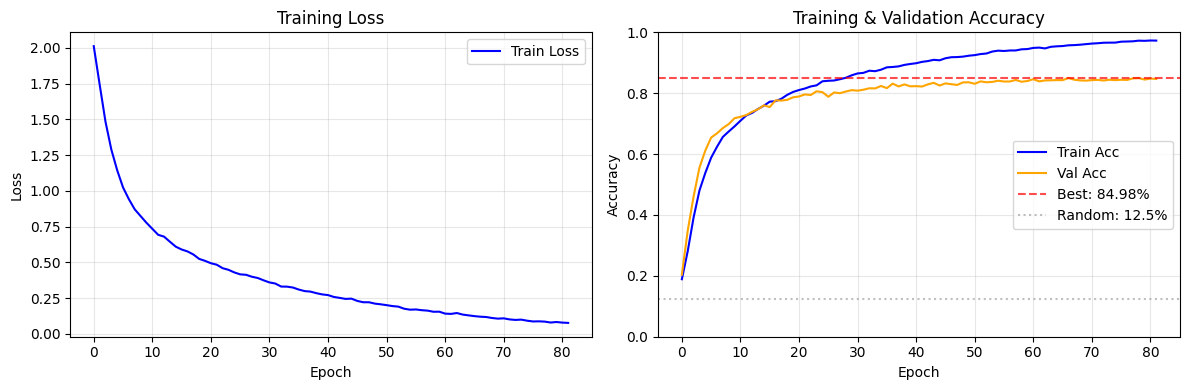

[OK] Training curves saved to /Users/mikul/Library/CloudStorage/OneDrive-Personal/College Undergrad/Junior Semester 1/Deep Learning for CV/VANS_output/results/training_curves.png


In [46]:
#@title 6.4 Training Curves Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[1].plot(history['val_acc'], label='Val Acc', color='orange')
axes[1].axhline(y=best_val_acc, color='red', linestyle='--', alpha=0.7, label=f'Best: {best_val_acc:.2%}')
axes[1].axhline(y=0.125, color='gray', linestyle=':', alpha=0.5, label='Random: 12.5%')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"[OK] Training curves saved to {RESULTS_DIR}/training_curves.png")

---
# SECTION 7: EVALUATION
---

In [47]:
#@title 7.1 Test Set Evaluation
import torch
import os

# Initialize results to None
test_acc = None
test_config_acc = None

checkpoint_path = os.path.join(CHECKPOINT_DIR, 'best_model.pt')

if not os.path.exists(checkpoint_path):
    print(f"[ERROR] No checkpoint found at: {checkpoint_path}")
    print("\nYou need to run Section 6 (Training) first!")
elif 'test_loader' not in dir():
    print("[ERROR] test_loader not defined. Run cells 4.1 and 4.2 first.")
elif 'model' not in dir():
    print("[ERROR] model not defined. Run cell 5.4 first.")
elif 'evaluate' not in dir():
    print("[ERROR] evaluate function not defined. Run cell 6.2 first.")
else:
    # Load best model
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(DEVICE)
    
    print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
    print(f"Validation accuracy at save: {checkpoint['val_acc']:.2%}\n")
    
    # Evaluate on test set
    test_acc, test_config_acc = evaluate(model, test_loader)
    
    print("="*60)
    print("TEST SET RESULTS")
    print("="*60)
    print(f"\nOverall Accuracy: {test_acc:.2%}")
    print(f"\nPer-Configuration Breakdown:")
    print("-"*40)
    
    for cfg in sorted(test_config_acc.keys()):
        acc = test_config_acc[cfg]
        short_name = CONFIG_SHORT.get(cfg, cfg[:15])
        bar = '#' * int(acc * 30) + '-' * (30 - int(acc * 30))
        print(f"{short_name:15} {bar} {acc:.1%}")
    
    print("-"*40)
    print(f"{'OVERALL':15} {'#' * int(test_acc * 30)}{'-' * (30 - int(test_acc * 30))} {test_acc:.1%}")
    print(f"{'Random guess':15} {'-' * 30} 12.5%")


Loaded best model from epoch 67
Validation accuracy at save: 84.98%



TEST SET RESULTS

Overall Accuracy: 84.38%

Per-Configuration Breakdown:
----------------------------------------
center          #############################- 98.4%
dist_4          #####################--------- 72.6%
dist_9          #######################------- 77.3%
in_out          ###########################--- 91.4%
in_out_grid     ########################------ 81.5%
left_right      #########################----- 85.6%
up_down         #########################----- 84.0%
----------------------------------------
OVERALL         #########################----- 84.4%
Random guess    ------------------------------ 12.5%


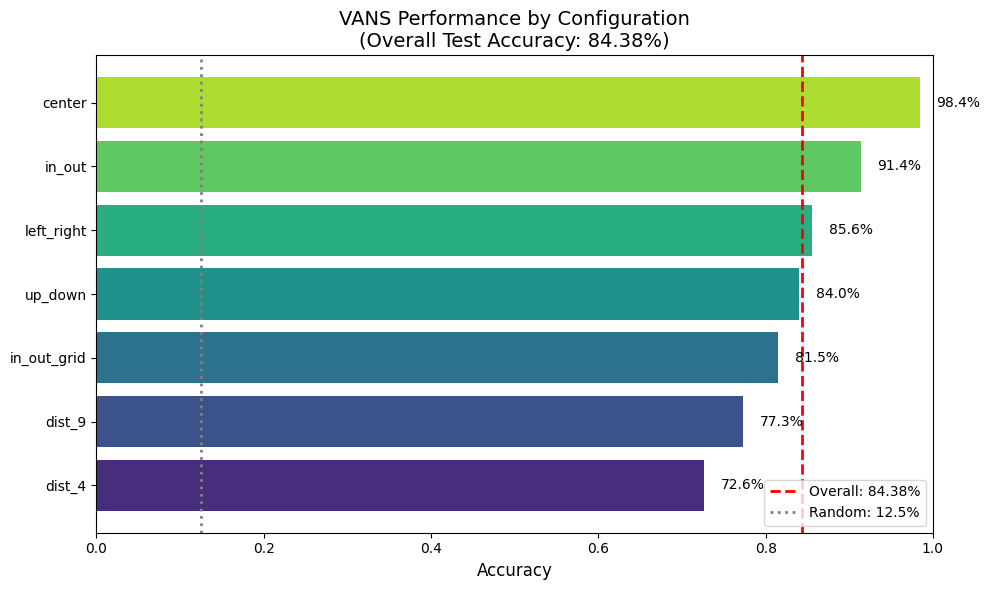

[OK] Configuration breakdown saved to /Users/mikul/Library/CloudStorage/OneDrive-Personal/College Undergrad/Junior Semester 1/Deep Learning for CV/VANS_output/results/config_breakdown.png


In [48]:
#@title 7.2 Per-Configuration Analysis
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

# Check if test evaluation was run
if 'test_config_acc' not in dir() or 'test_acc' not in dir():
    print("[ERROR] test_config_acc not defined!")
    print("Run cell 7.1 (Test Set Evaluation) first.")
else:
    # Create results dataframe
    results_df = pd.DataFrame([
        {'Configuration': CONFIG_SHORT.get(cfg, cfg[:15]), 'Accuracy': acc}
        for cfg, acc in test_config_acc.items()
    ])
    results_df = results_df.sort_values('Accuracy', ascending=True)

    # Bar plot
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("viridis", len(results_df))
    bars = plt.barh(results_df['Configuration'], results_df['Accuracy'], color=colors)

    plt.xlabel('Accuracy', fontsize=12)
    plt.title(f'VANS Performance by Configuration\n(Overall Test Accuracy: {test_acc:.2%})', fontsize=14)
    plt.axvline(x=test_acc, color='red', linestyle='--', linewidth=2, label=f'Overall: {test_acc:.2%}')
    plt.axvline(x=0.125, color='gray', linestyle=':', linewidth=2, label='Random: 12.5%')
    plt.legend(loc='lower right')
    plt.xlim(0, 1)

    # Add value labels
    for bar, acc in zip(bars, results_df['Accuracy']):
        plt.text(acc + 0.02, bar.get_y() + bar.get_height()/2, f'{acc:.1%}', 
                 va='center', fontsize=10)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'config_breakdown.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"[OK] Configuration breakdown saved to {RESULTS_DIR}/config_breakdown.png")


In [49]:
#@title 7.3 Confusion Analysis
import numpy as np
from collections import defaultdict

# Collect predictions and analyze confusion
model.eval()
confusion_data = defaultdict(lambda: {'correct': 0, 'total': 0, 'pred_dist': np.zeros(8)})

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Analyzing'):
        context = batch['context'].to(DEVICE)
        candidates = batch['candidates'].to(DEVICE)
        targets = batch['target'].to(DEVICE)
        configs = batch['config']
        
        scores, _ = model(context, candidates)
        preds = scores.argmax(dim=1)
        
        for i in range(len(targets)):
            cfg = configs[i]
            confusion_data[cfg]['total'] += 1
            confusion_data[cfg]['correct'] += (preds[i] == targets[i]).item()
            confusion_data[cfg]['pred_dist'][preds[i].item()] += 1

# Print analysis
print("\nPrediction Distribution Analysis:")
print("="*60)

for cfg in sorted(confusion_data.keys()):
    data = confusion_data[cfg]
    acc = data['correct'] / data['total']
    pred_dist = data['pred_dist'] / data['total']
    
    print(f"\n{cfg}:")
    print(f"  Accuracy: {acc:.2%}")
    print(f"  Prediction distribution: {np.round(pred_dist * 100, 1)}")
    
    # Check for position bias
    entropy = -np.sum(pred_dist * np.log(pred_dist + 1e-10))
    max_entropy = np.log(8)  # uniform distribution
    print(f"  Prediction entropy: {entropy:.2f} / {max_entropy:.2f} (higher = more uniform)")

Analyzing: 100%|██████████| 110/110 [00:03<00:00, 33.49it/s]


Prediction Distribution Analysis:

center_single:
  Accuracy: 98.40%
  Prediction distribution: [11.5 14.3 12.8 12.4 12.2 14.1 11.7 10.8]
  Prediction entropy: 2.08 / 2.08 (higher = more uniform)

distribute_four:
  Accuracy: 72.65%
  Prediction distribution: [10.7 15.1 11.4 10.8 11.7 12.6 13.7 13.8]
  Prediction entropy: 2.07 / 2.08 (higher = more uniform)

distribute_nine:
  Accuracy: 77.25%
  Prediction distribution: [12.5 11.2 12.2 16.  11.  10.9 13.9 12.1]
  Prediction entropy: 2.07 / 2.08 (higher = more uniform)

in_center_single_out_center_single:
  Accuracy: 91.38%
  Prediction distribution: [13.4 14.  14.6 11.7 12.6 12.1 11.  10.4]
  Prediction entropy: 2.07 / 2.08 (higher = more uniform)

in_distribute_four_out_center_single:
  Accuracy: 81.46%
  Prediction distribution: [12.5 12.9 10.5 13.6 13.7 11.9 12.9 11.8]
  Prediction entropy: 2.08 / 2.08 (higher = more uniform)

left_center_single_right_center_single:
  Accuracy: 85.57%
  Prediction distribution: [12.7 11.7 12.3 13.5

---
# SECTION 8: ABLATIONS & ANALYSIS
---

In [50]:
#@title 8.1 Ablation Studies (Optional)
# Run these if time permits to understand what contributes to performance

print("Ablation Study Plan:")
print("="*50)
print("""
1. Loss Ablation:
   - CE only (gamma=0)
   - Margin only (alpha=0) 
   - Full (alpha=1, gamma=0.1)

2. Architecture Ablation:
   - 2 transformer layers vs 4 vs 6
   - 256 hidden dim vs 512 vs 1024
   - Without row/col embeddings

3. Attention Ablation:
   - Without cross-attention to context
   - Without self-attention among candidates
   - Without both

To run: Create new model with modified config, train, evaluate.
""")

# Example: Quick ablation for CE-only loss
# Uncomment to run (takes ~30 min)

# print("\nRunning CE-only ablation...")
# CONFIG_ABLATION = CONFIG.copy()
# CONFIG_ABLATION['gamma'] = 0  # No margin loss
# CONFIG_ABLATION['max_epochs'] = 50  # Shorter training
# 
# model_ablation = VANS().to(DEVICE)
# optimizer_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=CONFIG['lr'])
# # ... train and evaluate ...

Ablation Study Plan:

1. Loss Ablation:
   - CE only (gamma=0)
   - Margin only (alpha=0) 
   - Full (alpha=1, gamma=0.1)

2. Architecture Ablation:
   - 2 transformer layers vs 4 vs 6
   - 256 hidden dim vs 512 vs 1024
   - Without row/col embeddings

3. Attention Ablation:
   - Without cross-attention to context
   - Without self-attention among candidates
   - Without both

To run: Create new model with modified config, train, evaluate.



In [51]:
#@title 8.2 Error Analysis
import numpy as np

# Collect all errors for analysis
errors = []
model.eval()

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Collecting errors'):
        context = batch['context'].to(DEVICE)
        candidates = batch['candidates'].to(DEVICE)
        targets = batch['target'].to(DEVICE)
        configs = batch['config']
        
        scores, _ = model(context, candidates)
        preds = scores.argmax(dim=1)
        
        for i in range(len(targets)):
            if preds[i] != targets[i]:
                # Calculate confidence
                probs = torch.softmax(scores[i], dim=0)
                errors.append({
                    'config': configs[i],
                    'predicted': preds[i].item(),
                    'actual': targets[i].item(),
                    'confidence': probs[preds[i]].item(),
                    'correct_prob': probs[targets[i]].item(),
                    'margin': (probs[preds[i]] - probs[targets[i]]).item()
                })

print(f"\nTotal errors: {len(errors)} / {len(test_dataset)} ({len(errors)/len(test_dataset):.1%})")

# Error distribution by config
print("\nErrors by configuration:")
error_by_config = {}
for e in errors:
    cfg = e['config']
    error_by_config[cfg] = error_by_config.get(cfg, 0) + 1

for cfg, count in sorted(error_by_config.items(), key=lambda x: -x[1]):
    print(f"  {cfg}: {count} errors")

# Analyze confidence on errors
print("\nError confidence analysis:")
confidences = [e['confidence'] for e in errors]
margins = [e['margin'] for e in errors]
print(f"  Mean confidence on wrong answer: {np.mean(confidences):.2%}")
print(f"  Mean margin (wrong - correct): {np.mean(margins):.2%}")

# High confidence errors (model was very wrong)
high_conf_errors = [e for e in errors if e['confidence'] > 0.5]
print(f"\nHigh confidence errors (>50%): {len(high_conf_errors)}")


Total errors: 1091 / 6986 (15.6%)

Errors by configuration:
  distribute_four: 273 errors
  distribute_nine: 227 errors
  in_distribute_four_out_center_single: 185 errors
  up_center_single_down_center_single: 160 errors
  left_center_single_right_center_single: 144 errors
  in_center_single_out_center_single: 86 errors
  center_single: 16 errors

Error confidence analysis:
  Mean confidence on wrong answer: 77.96%
  Mean margin (wrong - correct): 62.74%

High confidence errors (>50%): 1027


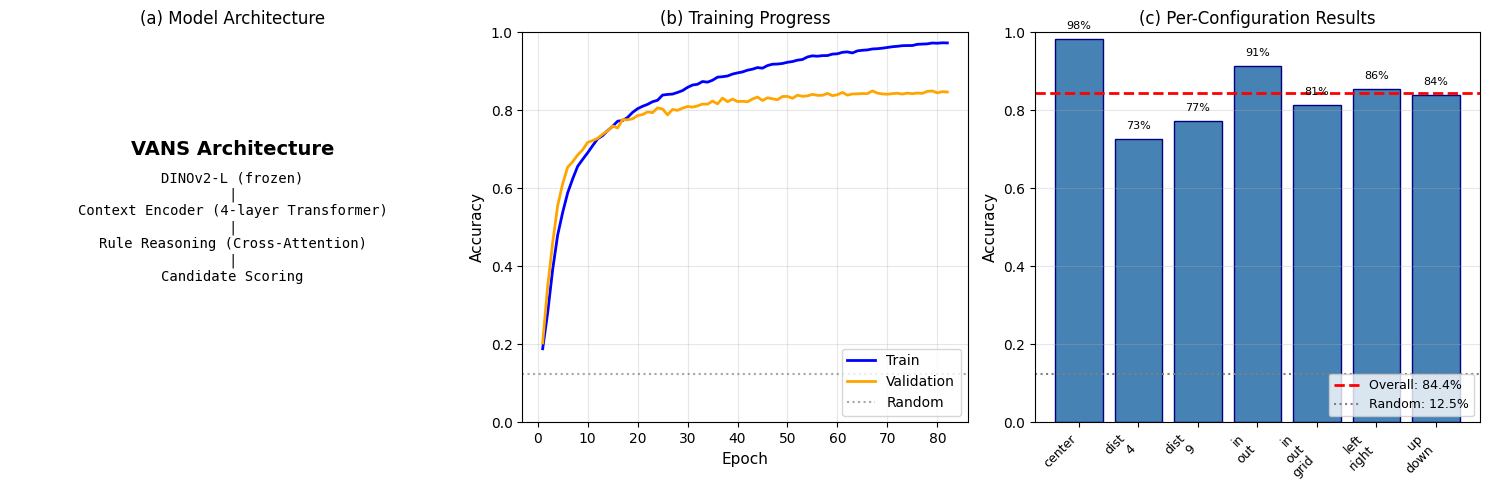


[OK] Paper figure saved to /Users/mikul/Library/CloudStorage/OneDrive-Personal/College Undergrad/Junior Semester 1/Deep Learning for CV/VANS_output/results/paper_figure.png

FINAL RESULTS SUMMARY

Test Accuracy: 84.38%
Best Validation Accuracy: 84.98%

All results saved to: /Users/mikul/Library/CloudStorage/OneDrive-Personal/College Undergrad/Junior Semester 1/Deep Learning for CV/VANS_output/results/


In [52]:
#@title 8.3 Summary Visualizations for Paper
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create summary figure for paper
fig = plt.figure(figsize=(15, 5))

# Plot 1: Architecture diagram (text placeholder)
ax1 = fig.add_subplot(131)
ax1.text(0.5, 0.7, 'VANS Architecture', ha='center', va='center', fontsize=14, fontweight='bold')
ax1.text(0.5, 0.5, 'DINOv2-L (frozen)\n|\nContext Encoder (4-layer Transformer)\n|\nRule Reasoning (Cross-Attention)\n|\nCandidate Scoring', 
         ha='center', va='center', fontsize=10, family='monospace')
ax1.set_title('(a) Model Architecture', fontsize=12)
ax1.axis('off')
ax1.set_facecolor('#f0f0f0')

# Plot 2: Training curves
ax2 = fig.add_subplot(132)
epochs = range(1, len(history['train_acc']) + 1)
ax2.plot(epochs, history['train_acc'], label='Train', color='blue', linewidth=2)
ax2.plot(epochs, history['val_acc'], label='Validation', color='orange', linewidth=2)
ax2.axhline(y=0.125, color='gray', linestyle=':', alpha=0.7, label='Random')
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy', fontsize=11)
ax2.set_title('(b) Training Progress', fontsize=12)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# Plot 3: Per-config performance
ax3 = fig.add_subplot(133)
configs = sorted(test_config_acc.keys())
accs = [test_config_acc[c] for c in configs]
short_names = [CONFIG_SHORT.get(c, c[:10]).replace('_', '\n') for c in configs]

bars = ax3.bar(range(len(configs)), accs, color='steelblue', edgecolor='navy', linewidth=1)
ax3.axhline(y=test_acc, color='red', linestyle='--', linewidth=2, label=f'Overall: {test_acc:.1%}')
ax3.axhline(y=0.125, color='gray', linestyle=':', linewidth=1.5, label='Random: 12.5%')

ax3.set_xticks(range(len(configs)))
ax3.set_xticklabels(short_names, rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Accuracy', fontsize=11)
ax3.set_title('(c) Per-Configuration Results', fontsize=12)
ax3.legend(loc='lower right', fontsize=9)
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accs):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{acc:.0%}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'paper_figure.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n[OK] Paper figure saved to {RESULTS_DIR}/paper_figure.png")
print(f"\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Best Validation Accuracy: {best_val_acc:.2%}")
print(f"\nAll results saved to: {RESULTS_DIR}/")

# Summary

## Results

| Metric | Value |
|--------|-------|
| Test Accuracy | **TBD** |
| Best Val Accuracy | **TBD** |
| Training Time | **TBD** |

## Files Saved

- `{FEATURES_DIR}/all_features.pt` - Pre-extracted DINOv2 features
- `{CHECKPOINT_DIR}/best_model.pt` - Best model checkpoint
- `{RESULTS_DIR}/training_curves.png` - Training curves
- `{RESULTS_DIR}/config_breakdown.png` - Per-config results
- `{RESULTS_DIR}/paper_figure.png` - Summary figure for paper

---